In [1]:
import glob
import h5py
import shutil
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug as aug
import imgaug.augmenters as iaa

import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from keras.engine.topology import Layer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, Activation, MaxPool2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical

import tensorflow as tf
color = sns.color_palette()
%matplotlib inline

Using TensorFlow backend.


In [2]:
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(2)
tf.set_random_seed(2)
aug.seed(2)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

K.set_session(sess)


In [3]:
# Define path to the data directory
#root_dir = os.path.abspath('.')
root_dir = os.path.abspath('D:\pneumonia detection\chest_xray')
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

train_dir

'D:\\pneumonia detection\\chest_xray\\train'

In [4]:
train_normal_cases_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_cases_dir = os.path.join(train_dir, 'PNEUMONIA')

print(train_pneumonia_cases_dir)

#train_normal_cases = train_normal_cases_dir.glob('*.jpeg')
#train_pneumonia_cases = train_pneumonia_cases_dir.glob('*.jpeg')

train_normal_cases = [f for f in glob.glob(train_normal_cases_dir + "**/*.jpeg", recursive=True)]
train_pneumonia_cases = [f for f in glob.glob(train_pneumonia_cases_dir + "**/*.jpeg", recursive=True)]

print(type(train_pneumonia_cases))
print(train_pneumonia_cases[:5])

train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in train_normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in train_pneumonia_cases:
    train_data.append((img, 1))
    
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
print(train_data.head())

#type(train_data)

D:\pneumonia detection\chest_xray\train\PNEUMONIA
<class 'list'>
['D:\\pneumonia detection\\chest_xray\\train\\PNEUMONIA\\person1000_bacteria_2931.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\PNEUMONIA\\person1000_virus_1681.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\PNEUMONIA\\person1001_bacteria_2932.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\PNEUMONIA\\person1002_bacteria_2933.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\PNEUMONIA\\person1003_bacteria_2934.jpeg']
                                               image  label
0  D:\pneumonia detection\chest_xray\train\PNEUMO...      1
1  D:\pneumonia detection\chest_xray\train\PNEUMO...      1
2  D:\pneumonia detection\chest_xray\train\PNEUMO...      1
3  D:\pneumonia detection\chest_xray\train\PNEUMO...      1
4  D:\pneumonia detection\chest_xray\train\NORMAL...      0


1    3875
0    1341
Name: label, dtype: int64
5216


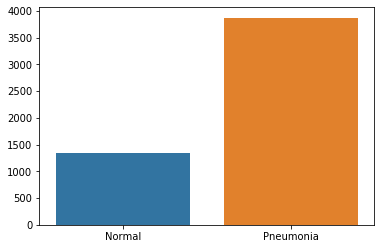

In [5]:
#EDA

cases_count = train_data['label'].value_counts()
print(cases_count)
print(train_data['label'].count())

sns.barplot(x=['Normal','Pneumonia'],y=[len(train_normal_cases),len(train_pneumonia_cases)])
                                

['D:\\pneumonia detection\\chest_xray\\train\\PNEUMONIA\\person1576_bacteria_4120.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\PNEUMONIA\\person1501_virus_2611.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\PNEUMONIA\\person1007_bacteria_2938.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\PNEUMONIA\\person965_bacteria_2890.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\PNEUMONIA\\person645_virus_1226.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\NORMAL\\IM-0511-0001-0002.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\NORMAL\\NORMAL2-IM-1157-0001.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\NORMAL\\IM-0539-0001.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\NORMAL\\IM-0547-0001.jpeg', 'D:\\pneumonia detection\\chest_xray\\train\\NORMAL\\NORMAL2-IM-0683-0001.jpeg']
Figure(2160x720)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015D98045898>


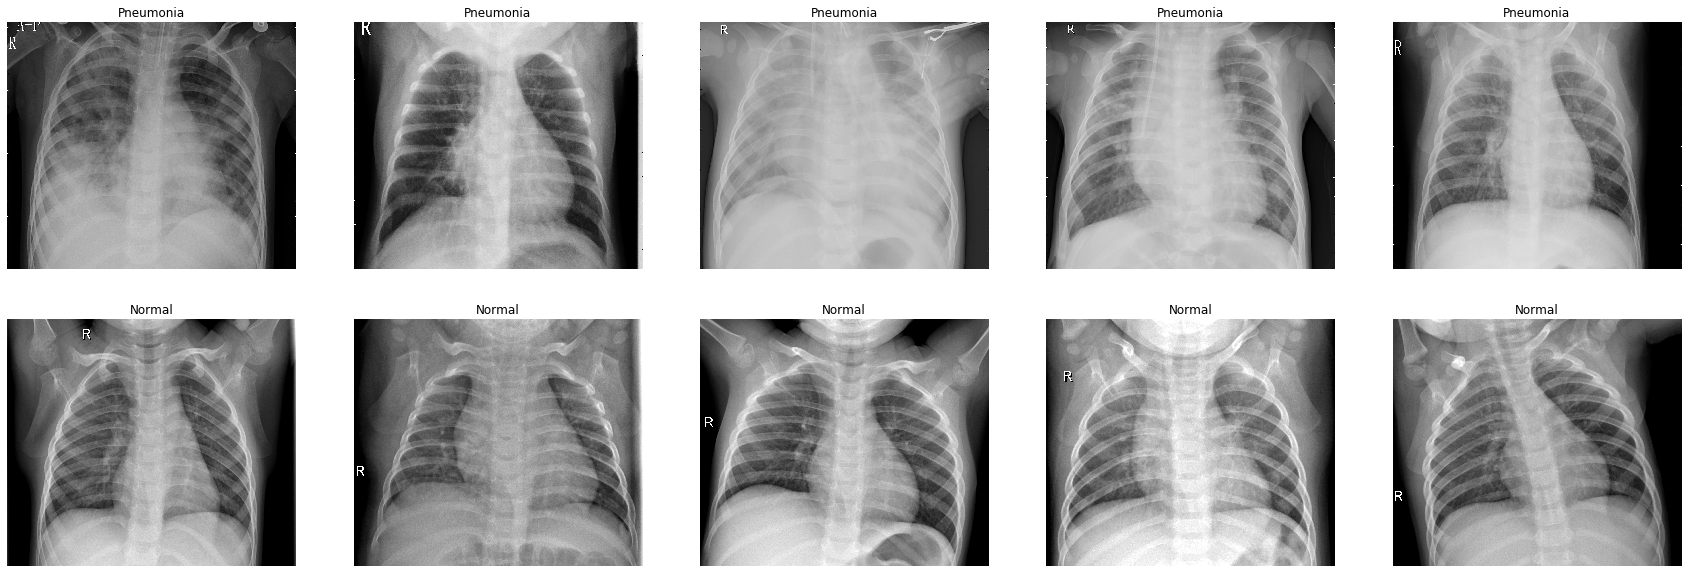

In [6]:
pneumonia_samples = (train_data[train_data['label'] == 1]['image'].iloc[:5]).tolist()
normal_samples= (train_data[train_data['label'] == 0]['image'].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples
print(samples)

f, ax = plt.subplots(2,5, figsize = (30, 10))

img = imread(samples[1])


print(f)
print(ax)

for i in range(10):
    img = imread(samples[i])
    #print("image size")
    #print(img.size)
    #print(img.shape)
    ax[i//5, i%5].imshow(img, cmap='gray')
    
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
    
plt.show()


In [7]:
val_normal_cases_dir = os.path.join(val_dir, 'NORMAL')
val_pneumonia_cases_dir = os.path.join(val_dir, 'PNEUMONIA')

print(val_normal_cases_dir)

val_normal_cases = [f for f in glob.glob(val_normal_cases_dir + "**/*.jpeg", recursive=True)]
val_pneumonia_cases = [f for f in glob.glob(val_pneumonia_cases_dir + "**/*.jpeg", recursive=True)]

print(val_pneumonia_cases[:5])

valid_data = []
valid_labels = []
"""
print(str(val_normal_cases[0]))
trial = cv2.imread(str(val_normal_cases[0]))
print(trial)
print(type(trial))
print(trial.shape)
print(trial.size)

#cv2.imshow('Image', trial) #crash in jupyter notebook
plt.imshow(trial)
"""
for img in val_normal_cases:
    img = cv2.imread(img)
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    # open cv read image using BGR, and matplotlib use RGB to display image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
for img in val_pneumonia_cases:
    img = cv2.imread(img)
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    # open cv read image using BGR, and matplotlib use RGB to display image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

D:\pneumonia detection\chest_xray\val\NORMAL
['D:\\pneumonia detection\\chest_xray\\val\\PNEUMONIA\\person1946_bacteria_4874.jpeg', 'D:\\pneumonia detection\\chest_xray\\val\\PNEUMONIA\\person1946_bacteria_4875.jpeg', 'D:\\pneumonia detection\\chest_xray\\val\\PNEUMONIA\\person1947_bacteria_4876.jpeg', 'D:\\pneumonia detection\\chest_xray\\val\\PNEUMONIA\\person1949_bacteria_4880.jpeg', 'D:\\pneumonia detection\\chest_xray\\val\\PNEUMONIA\\person1950_bacteria_4881.jpeg']


In [8]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [9]:
def data_gen(data, batch_size):
    n = len(data)
    steps = n // batch_size
    
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)
    
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [10]:
num_classes=2

#Build STN model
def build_model():
    sampling_size=(56, 56)
    
    image = Input(shape=(224,224,3), name='ImageInput')
    locnet = Conv2D(10, (5, 5))(image)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    locnet = Flatten()(locnet)
    locnet = Dense(50)(locnet)
    locnet = Activation('relu')(locnet)
    weights = get_initial_weights(50)
    locnet = Dense(6, weights=weights)(locnet)
    x = BilinearInterpolation(sampling_size)([image, locnet])
    x = Conv2D(10, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(num_classes)(x)
    x = Activation('softmax')(x)
    return Model(inputs=image, outputs=x)

import tensorflow as tf

def K_meshgrid(x, y):
    return tf.meshgrid(x, y)

def K_linspace(start, stop, num):
    return tf.linspace(start, stop, num)

class BilinearInterpolation(Layer):
    """Performs bilinear interpolation as a keras layer
    References
    ----------
    [1]  Spatial Transformer Networks, Max Jaderberg, et al.
    [2]  https://github.com/skaae/transformer_network
    [3]  https://github.com/EderSantana/seya
    """

    def __init__(self, output_size, **kwargs):
        self.output_size = output_size
        super(BilinearInterpolation, self).__init__(**kwargs)

    def compute_output_shape(self, input_shapes):
        height, width = self.output_size
        num_channels = input_shapes[0][-1]
        return (None, height, width, num_channels)

    def call(self, tensors, mask=None):
        X, transformation = tensors
        output = self._transform(X, transformation, self.output_size)
        return output

    def _interpolate(self, image, sampled_grids, output_size):

        batch_size = K.shape(image)[0]
        height = K.shape(image)[1]
        width = K.shape(image)[2]
        num_channels = K.shape(image)[3]

        x = K.cast(K.flatten(sampled_grids[:, 0:1, :]), dtype='float32')
        y = K.cast(K.flatten(sampled_grids[:, 1:2, :]), dtype='float32')

        x = .5 * (x + 1.0) * K.cast(width, dtype='float32')
        y = .5 * (y + 1.0) * K.cast(height, dtype='float32')

        x0 = K.cast(x, 'int32')
        x1 = x0 + 1
        y0 = K.cast(y, 'int32')
        y1 = y0 + 1

        max_x = int(K.int_shape(image)[2] - 1)
        max_y = int(K.int_shape(image)[1] - 1)

        x0 = K.clip(x0, 0, max_x)
        x1 = K.clip(x1, 0, max_x)
        y0 = K.clip(y0, 0, max_y)
        y1 = K.clip(y1, 0, max_y)

        pixels_batch = K.arange(0, batch_size) * (height * width)
        pixels_batch = K.expand_dims(pixels_batch, axis=-1)
        flat_output_size = output_size[0] * output_size[1]
        base = K.repeat_elements(pixels_batch, flat_output_size, axis=1)
        base = K.flatten(base)

        # base_y0 = base + (y0 * width)
        base_y0 = y0 * width
        base_y0 = base + base_y0
        # base_y1 = base + (y1 * width)
        base_y1 = y1 * width
        base_y1 = base_y1 + base

        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = K.reshape(image, shape=(-1, num_channels))
        flat_image = K.cast(flat_image, dtype='float32')
        pixel_values_a = K.gather(flat_image, indices_a)
        pixel_values_b = K.gather(flat_image, indices_b)
        pixel_values_c = K.gather(flat_image, indices_c)
        pixel_values_d = K.gather(flat_image, indices_d)

        x0 = K.cast(x0, 'float32')
        x1 = K.cast(x1, 'float32')
        y0 = K.cast(y0, 'float32')
        y1 = K.cast(y1, 'float32')

        area_a = K.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = K.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = K.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = K.expand_dims(((x - x0) * (y - y0)), 1)

        values_a = area_a * pixel_values_a
        values_b = area_b * pixel_values_b
        values_c = area_c * pixel_values_c
        values_d = area_d * pixel_values_d
        return values_a + values_b + values_c + values_d

    def _make_regular_grids(self, batch_size, height, width):
        # making a single regular grid
        x_linspace = K_linspace(-1., 1., width)
        y_linspace = K_linspace(-1., 1., height)
        x_coordinates, y_coordinates = K_meshgrid(x_linspace, y_linspace)
        x_coordinates = K.flatten(x_coordinates)
        y_coordinates = K.flatten(y_coordinates)
        ones = K.ones_like(x_coordinates)
        grid = K.concatenate([x_coordinates, y_coordinates, ones], 0)

        # repeating grids for each batch
        grid = K.flatten(grid)
        grids = K.tile(grid, K.stack([batch_size]))
        return K.reshape(grids, (batch_size, 3, height * width))

    def _transform(self, X, affine_transformation, output_size):
        batch_size, num_channels = K.shape(X)[0], K.shape(X)[3]
        transformations = K.reshape(affine_transformation,
                                    shape=(batch_size, 2, 3))
        # transformations = K.cast(affine_transformation[:, 0:2, :], 'float32')
        regular_grids = self._make_regular_grids(batch_size, *output_size)
        sampled_grids = K.batch_dot(transformations, regular_grids)
        interpolated_image = self._interpolate(X, sampled_grids, output_size)
        new_shape = (batch_size, output_size[0], output_size[1], num_channels)
        interpolated_image = K.reshape(interpolated_image, new_shape)
        return interpolated_image
    
def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights

In [11]:
model =  build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageInput (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 10) 760         ImageInput[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 110, 110, 10) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 121000)       0           max_pooling2d_1[0][0]            
_____________________________________

In [12]:
# Open the VGG16 weight file
f = h5py.File('C:\\Users\\Leo\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

f.close()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageInput (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 10) 760         ImageInput[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 110, 110, 10) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 121000)       0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
dense_1 (D

In [13]:
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [14]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [15]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                               class_weight={0:1.0, 1:0.45})

model.save_weights('keras_model_STN_v1_weights.h5')



Instructions for updating:
Use tf.cast instead.
Epoch 1/20
326/326 [==============================] - 128s 394ms/step - loss: 0.2168 - acc: 0.8313 - val_loss: 0.8599 - val_acc: 0.5625
Epoch 2/20
326/326 [==============================] - 99s 305ms/step - loss: 0.1116 - acc: 0.9306 - val_loss: 1.1180 - val_acc: 0.4375
Epoch 3/20
326/326 [==============================] - 86s 264ms/step - loss: 0.0967 - acc: 0.9356 - val_loss: 1.0414 - val_acc: 0.6250
Epoch 4/20
326/326 [==============================] - 76s 232ms/step - loss: 0.0895 - acc: 0.9429 - val_loss: 1.6353 - val_acc: 0.4375
Epoch 5/20
326/326 [==============================] - 75s 230ms/step - loss: 0.0681 - acc: 0.9588 - val_loss: 2.1420 - val_acc: 0.3750
Epoch 6/20
326/326 [==============================] - 74s 226ms/step - loss: 0.0670 - acc: 0.9580 - val_loss: 1.1442 - val_acc: 0.4375


In [16]:
# Load the model weights
model.load_weights("keras_model_STN_v1_weights.h5")

In [17]:
# Preparing test data
test_normal_cases_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_cases_dir = os.path.join(test_dir, 'PNEUMONIA')

test_normal_cases = [f for f in glob.glob(test_normal_cases_dir + "**/*.jpeg", recursive=True)]
test_pneumonia_cases = [f for f in glob.glob(test_pneumonia_cases_dir + "**/*.jpeg", recursive=True)]


test_data = []
test_labels = []

for img in test_normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in test_pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [18]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 2s 3ms/step
Loss on test set:  0.33218349908024836
Accuracy on test set:  0.8621794871794872


In [19]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

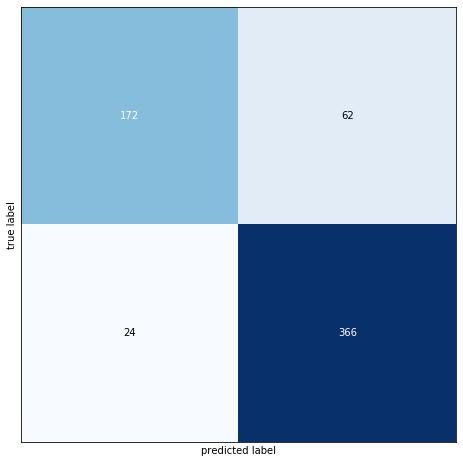

In [20]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.show()

In [21]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.4f}".format(recall))
print("Precision of the model is {:.4f}".format(precision))

Recall of the model is 0.9385
Precision of the model is 0.8551
